## Logistic Regression - optimal over and undersampling

In [1]:
import warnings
warnings.filterwarnings("ignore")
import time
import pickle

# core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# sklearn libraries
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression as LogisticRegression_sklearn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import scipy.stats as stats


# imblearn libraries
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as imbpipeline


# model evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve #, plot_roc_curve


# interpretation
from interpret.glassbox import (LogisticRegression)
from interpret import show
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

In [3]:
# load the dataset intended for cross-validation

df = pd.read_csv("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/02_Data/Cleaned/Clean_CV.csv")


In [4]:
# split into input (X) and output (y) variables

X = df.drop(columns=["fraud_bool"])
y = df["fraud_bool"]

X.shape

(397494, 50)

In [5]:
# find all numeric features
numeric_features = [x for x in df.columns if df[x].nunique() >= 10]

## Finding optimal Oversampling strategy

### Optimal Random Oversampling

In [ ]:

start_time = time.time()


scale_cols = numeric_features 

# Define the column transformer for scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), scale_cols)
    ])

# Define the logistic regression classifier
logreg = LogisticRegression_sklearn()

# Define the hyperparameters to search
param_dist = {
    'classifier__solver': ['saga'],
    'classifier__penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'classifier__C': stats.loguniform(1e-5, 100), 
    'classifier__class_weight': [None, 'balanced']
    }

# Define the cross-validation object with stratified sampling
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define scorings to calculate
scoring = ['f1', 'roc_auc', 'recall', 'precision', 'accuracy']

# Define a list of sampling strategies to try
# resulting ratio of minoritt/majority class in the dataset - initial ratio: 0.011152 = 0.0112
sampling_strategies = [0.0112, 0.0168, 0.025, 0.05, 0.075, 0.1, 0.2, 0.5, 1]

# Define dictionaries to store the best model parameters and evaluation metrics for each sampling strategy
best_params_OS = {}
best_scores_OS = {}

# Iterate over the sampling strategies
for strategy in sampling_strategies:
    print(f"Running with sampling strategy: {strategy}")
    
    # Define the pipeline
    pipe = imbpipeline([
        ('preprocessor', preprocessor),
        ('oversampler', RandomOverSampler(sampling_strategy=strategy, random_state=42)),
        ('classifier', logreg)
    ])
    
    # Define the RandomizedSearchCV object
    random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, cv=cv, scoring=scoring, refit='roc_auc', n_iter=20, random_state=42, n_jobs=-1)
    
    # Run RandomizedSearchCV
    random_search.fit(X, y)
    
    # Store the best model parameters and evaluation metrics
    best_params_OS[strategy] = random_search.best_params_
    best_scores_OS[strategy] = random_search.best_score_
    
    # Print the best parameters and evaluation metrics for the current strategy
    print("Best parameters:")
    print(random_search.best_params_)
    print("Best scores:")
    print(random_search.best_score_)
    print()

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time/60, 'mins')

# 20 min

Running with sampling strategy: 0.0112
Best parameters:
{'classifier__C': 0.1789838984867159, 'classifier__class_weight': None, 'classifier__penalty': 'none', 'classifier__solver': 'saga'}
Best scores:
0.7526562982724158

Running with sampling strategy: 0.0168
Best parameters:
{'classifier__C': 0.14024971326600358, 'classifier__class_weight': None, 'classifier__penalty': 'none', 'classifier__solver': 'saga'}
Best scores:
0.7523943111024479

Running with sampling strategy: 0.025
Best parameters:
{'classifier__C': 0.00018740223688836318, 'classifier__class_weight': None, 'classifier__penalty': 'none', 'classifier__solver': 'saga'}
Best scores:
0.7524695620321422

Running with sampling strategy: 0.05
Best parameters:
{'classifier__C': 0.14024971326600358, 'classifier__class_weight': None, 'classifier__penalty': 'none', 'classifier__solver': 'saga'}
Best scores:
0.7526812376395191

Running with sampling strategy: 0.075
Best parameters:
{'classifier__C': 0.00018740223688836318, 'classifier_

In [ ]:
best_params_OS

{0.0112: {'classifier__C': 0.1789838984867159,
  'classifier__class_weight': None,
  'classifier__penalty': 'none',
  'classifier__solver': 'saga'},
 0.0168: {'classifier__C': 0.14024971326600358,
  'classifier__class_weight': None,
  'classifier__penalty': 'none',
  'classifier__solver': 'saga'},
 0.025: {'classifier__C': 0.00018740223688836318,
  'classifier__class_weight': None,
  'classifier__penalty': 'none',
  'classifier__solver': 'saga'},
 0.05: {'classifier__C': 0.14024971326600358,
  'classifier__class_weight': None,
  'classifier__penalty': 'none',
  'classifier__solver': 'saga'},
 0.075: {'classifier__C': 0.00018740223688836318,
  'classifier__class_weight': None,
  'classifier__penalty': 'none',
  'classifier__solver': 'saga'},
 0.1: {'classifier__C': 0.14024971326600358,
  'classifier__class_weight': None,
  'classifier__penalty': 'none',
  'classifier__solver': 'saga'},
 0.2: {'classifier__C': 0.14024971326600358,
  'classifier__class_weight': None,
  'classifier__penalt

In [ ]:
best_scores_OS = pd.DataFrame.from_dict(best_scores_OS, orient='index', columns=['roc_auc'])
best_scores_OS



,roc_auc
0.0112,0.752656
0.0168,0.752394
0.0250,0.752470
0.0500,0.752681
0.0750,0.752816
0.1000,0.752936
0.2000,0.752903
0.5000,0.752697
1.0000,0.752407


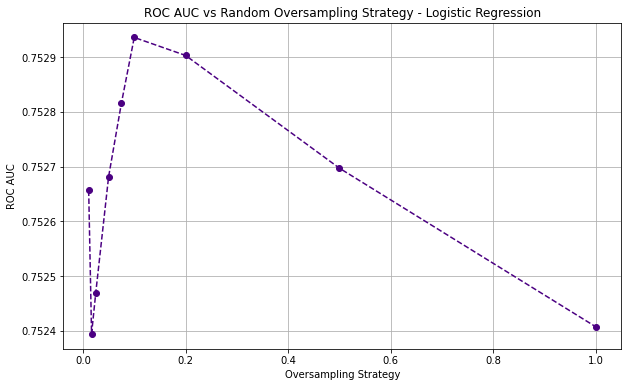

In [ ]:
# plot best_scores with roc_auc on y-axis and sampling_strategies on x-axis

plt.figure(figsize=(10, 6))
plt.plot(best_scores_OS.index, best_scores_OS['roc_auc'], marker='o', linestyle='--', color='indigo')
plt.xlabel('Oversampling Strategy')
plt.ylabel('ROC AUC')
plt.title('ROC AUC vs Random Oversampling Strategy - Logistic Regression')
plt.grid()

# save the plot
plt.savefig('LR_ROC_AUC_vs_Oversampling_Strategy.png', dpi=300)

plt.show()


### Optimal SMOTE resampling

In [ ]:
start_time = time.time()

scale_cols = numeric_features 

# Define the column transformer for scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), scale_cols)
    ])

# Define the logistic regression classifier
logreg = LogisticRegression_sklearn()

# Define the hyperparameters to search
param_dist = {
    'classifier__solver': ['saga'],
    'classifier__penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'classifier__C': stats.loguniform(1e-5, 100), 
    'classifier__class_weight': [None, 'balanced']
    }

# Define the cross-validation object with stratified sampling
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define scorings to calculate
scoring = ['f1', 'roc_auc', 'recall', 'precision', 'accuracy']

# Define a list of sampling strategies to try
# resulting ratio of minoritt/majority class in the dataset - initial ratio: 0.011152 = 0.0112
sampling_strategies = [0.0112, 0.0168, 0.025, 0.05, 0.075, 0.1, 0.2, 0.5, 1]

# Define dictionaries to store the best model parameters and evaluation metrics for each sampling strategy
best_params_SMOTE = {}
best_scores_SMOTE = {}

# Iterate over the sampling strategies
for strategy in sampling_strategies:
    print(f"Running with sampling strategy: {strategy}")
    
    # Define the pipeline
    pipe = imbpipeline([
        ('preprocessor', preprocessor),
        ('oversampler', SMOTE(sampling_strategy=strategy, random_state=42, n_jobs=-1)),
        ('classifier', logreg)
    ])
    
    # Define the RandomizedSearchCV object
    random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, cv=cv, scoring=scoring, refit='roc_auc', n_iter=20, random_state=42, n_jobs=-1)
    
    # Run RandomizedSearchCV
    random_search.fit(X, y)
    
    # Store the best model parameters and evaluation metrics
    best_params_SMOTE[strategy] = random_search.best_params_
    best_scores_SMOTE[strategy] = random_search.best_score_
    
    # Print the best parameters and evaluation metrics for the current strategy
    print("Best parameters:")
    print(random_search.best_params_)
    print("Best scores:")
    print(random_search.best_score_)
    print()

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time/60, 'mins')

# 20 min

Running with sampling strategy: 0.0112
Best parameters:
{'classifier__C': 0.1789838984867159, 'classifier__class_weight': None, 'classifier__penalty': 'none', 'classifier__solver': 'saga'}
Best scores:
0.7526659646463099

Running with sampling strategy: 0.0168
Best parameters:
{'classifier__C': 1.330324510152291, 'classifier__class_weight': None, 'classifier__penalty': 'none', 'classifier__solver': 'saga'}
Best scores:
0.7525385097541535

Running with sampling strategy: 0.025
Best parameters:
{'classifier__C': 0.14024971326600358, 'classifier__class_weight': None, 'classifier__penalty': 'none', 'classifier__solver': 'saga'}
Best scores:
0.752395496804153

Running with sampling strategy: 0.05
Best parameters:
{'classifier__C': 1.330324510152291, 'classifier__class_weight': None, 'classifier__penalty': 'none', 'classifier__solver': 'saga'}
Best scores:
0.7523902462334883

Running with sampling strategy: 0.075
Best parameters:
{'classifier__C': 0.00018740223688836318, 'classifier__class_w

In [ ]:
best_scores_SMOTE = pd.DataFrame.from_dict(best_scores_SMOTE, orient='index', columns=['roc_auc'])
best_scores_SMOTE


,roc_auc
0.0112,0.752666
0.0168,0.752539
0.0250,0.752395
0.0500,0.752390
0.0750,0.752151
0.1000,0.752074
0.2000,0.751953
0.5000,0.751718
1.0000,0.751329


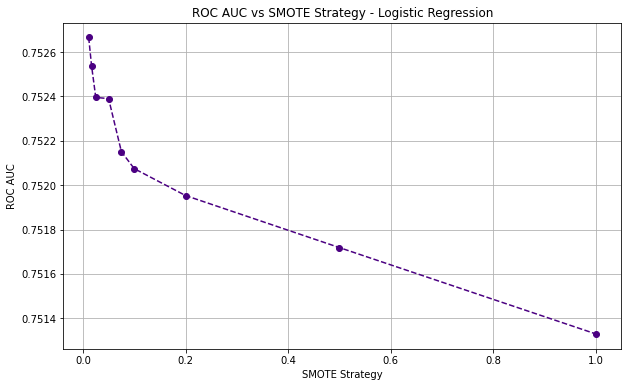

In [ ]:
# plot best_scores with roc_auc on y-axis and sampling_strategies on x-axis

plt.figure(figsize=(10, 6))

plt.plot(best_scores_SMOTE.index, best_scores_SMOTE['roc_auc'], marker='o', linestyle='--', color='indigo')
plt.xlabel('SMOTE Strategy')
plt.ylabel('ROC AUC')
plt.title('ROC AUC vs SMOTE Strategy - Logistic Regression')
plt.grid()

# save the plot
plt.savefig('LR_ROC_AUC_vs_SMOTE_Strategy.png', dpi=300)

plt.show()


## Optimal Undersampling strategy

### Optimal Random Undersampling

In [5]:
start_time = time.time()

scale_cols = numeric_features 

# Define the column transformer for scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), scale_cols)
    ])

# Define the logistic regression classifier
logreg = LogisticRegression_sklearn()

# Define the hyperparameters to search
param_dist = {
    'classifier__solver': ['saga'],
    'classifier__penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'classifier__C': stats.loguniform(1e-5, 100), 
    'classifier__class_weight': [None, 'balanced']
    }

# Define the cross-validation object with stratified sampling
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define scorings to calculate
scoring = ['f1', 'roc_auc', 'recall', 'precision', 'accuracy']

# Define a list of sampling strategies to try
# resulting ratio of minoritt/majority class in the dataset - initial ratio: 0.011152 = 0.0112
sampling_strategies = [0.0112, 0.0168, 0.025, 0.05, 0.075, 0.1, 0.2, 0.5, 1]

# Define dictionaries to store the best model parameters and evaluation metrics for each sampling strategy
best_params_US = {}
best_scores_US = {}

# Iterate over the sampling strategies
for strategy in sampling_strategies:
    print(f"Running with sampling strategy: {strategy}")
    
    # Define the pipeline
    pipe = imbpipeline([
        ('preprocessor', preprocessor),
        ('oversampler', RandomUnderSampler(sampling_strategy=strategy, random_state=42)),
        ('classifier', logreg)
    ])
    
    # Define the RandomizedSearchCV object
    random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, cv=cv, scoring=scoring, refit='roc_auc', n_iter=20, random_state=42, n_jobs=-1)
    
    # Run RandomizedSearchCV
    random_search.fit(X, y)
    
    # Store the best model parameters and evaluation metrics
    best_params_US[strategy] = random_search.best_params_
    best_scores_US[strategy] = random_search.best_score_
    
    # Print the best parameters and evaluation metrics for the current strategy
    print("Best parameters:")
    print(random_search.best_params_)
    print("Best scores:")
    print(random_search.best_score_)
    print()

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time/60, 'mins')

# 11 min


Running with sampling strategy: 0.0112


KeyboardInterrupt: 

In [ ]:
best_params_US

{0.0112: {'classifier__C': 0.14024971326600358,
  'classifier__class_weight': None,
  'classifier__penalty': 'none',
  'classifier__solver': 'saga'},
 0.0168: {'classifier__C': 0.1789838984867159,
  'classifier__class_weight': None,
  'classifier__penalty': 'none',
  'classifier__solver': 'saga'},
 0.025: {'classifier__C': 0.00018740223688836318,
  'classifier__class_weight': None,
  'classifier__penalty': 'none',
  'classifier__solver': 'saga'},
 0.05: {'classifier__C': 0.14024971326600358,
  'classifier__class_weight': None,
  'classifier__penalty': 'none',
  'classifier__solver': 'saga'},
 0.075: {'classifier__C': 1.330324510152291,
  'classifier__class_weight': None,
  'classifier__penalty': 'none',
  'classifier__solver': 'saga'},
 0.1: {'classifier__C': 0.00018740223688836318,
  'classifier__class_weight': None,
  'classifier__penalty': 'none',
  'classifier__solver': 'saga'},
 0.2: {'classifier__C': 0.00018740223688836318,
  'classifier__class_weight': None,
  'classifier__penal

In [ ]:
best_scores_US = pd.DataFrame.from_dict(best_scores_US, orient='index', columns=['roc_auc'])
best_scores_US


,roc_auc
0.0112,0.752756
0.0168,0.752837
0.0250,0.752753
0.0500,0.752921
0.0750,0.752978
0.1000,0.752906
0.2000,0.752939
0.5000,0.752783
1.0000,0.752291


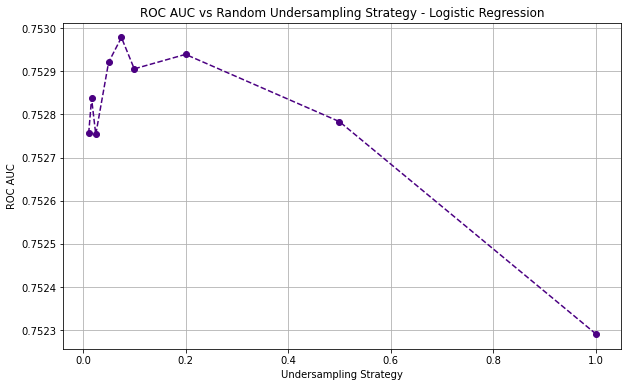

In [ ]:
# plot best_scores with roc_auc on y-axis and sampling_strategies on x-axis

plt.figure(figsize=(10, 6))

plt.plot(best_scores_US.index, best_scores_US['roc_auc'], marker='o', linestyle='--', color='indigo')
plt.xlabel('Undersampling Strategy')
plt.ylabel('ROC AUC')
plt.title('ROC AUC vs Random Undersampling Strategy - Logistic Regression')
plt.grid()

# save the plot
plt.savefig('LR_ROC_AUC_vs_RandUndersampling.png', dpi=300)

plt.show()



### Outcome:

The "best" resampling strategy is: Random UNDERSAMPLING @ sampling_strategy = 0.1

Run cross-validation once again with this strategy and keep the results (same as in imbalanced training)



## Final Model training with the "optimal" resampling strategy

### Cross Validation - for graphics generation

In [37]:
start_time = time.time()

# Define the columns that need rescaling
scale_cols = numeric_features

# Define the column transformer for scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), scale_cols)
    ])

# Define the logistic regression classifier
logreg = LogisticRegression_sklearn()

# Define the pipeline
pipe = imbpipeline([
    ('preprocessor', preprocessor),
    ('oversampler', RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
    ('classifier', logreg)
])

# Define the hyperparameters to search
param_dist = {
    'classifier__solver': ['saga'],
    'classifier__penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'classifier__C': stats.loguniform(1e-5, 100), 
    'classifier__class_weight': [None, 'balanced']
    }


# Define the cross-validation object with stratified sampling
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define scorings to calculate
scoring = ['f1', 'roc_auc', 'recall', 'precision', 'accuracy']

# Define the RandomizedSearchCV object
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, cv=cv, scoring=scoring, refit='roc_auc', n_iter=30, random_state=42, n_jobs=-1)

# Fit the pipeline with RandomizedSearchCV
random_search.fit(X, y)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time)

Execution time: 34.80871534347534


In [38]:
# Print the best score and parameters
print("Best Score: ", random_search.best_score_)
print("Best Parameters: ", random_search.best_params_)


# store the best parameters

best_C = random_search.best_params_['classifier__C']
best_class_weight = random_search.best_params_['classifier__class_weight']
best_penalty = random_search.best_params_['classifier__penalty']
best_solver = random_search.best_params_['classifier__solver']


Best Score:  0.7529058004859234
Best Parameters:  {'classifier__C': 0.1789838984867159, 'classifier__class_weight': None, 'classifier__penalty': 'none', 'classifier__solver': 'saga'}


In [39]:
# Store the results
logreg_results = pd.DataFrame(random_search.cv_results_)

In [40]:
# save results of the randomized search
logreg_results.to_csv("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/03_Model/32_SMOTE_output/LogisticRegression_CV_results.csv", index=False)

In [41]:
# create a new dataframe which contains ROC AUC scores and their ranking
logreg_results_auc = logreg_results[['mean_test_roc_auc', 'rank_test_roc_auc']]

# sort the values by the rank of ROC AUC scores with the worst score on top
logreg_results_auc = logreg_results_auc.sort_values(by=['rank_test_roc_auc'], ascending=False)

# drop null values
logreg_results_auc = logreg_results_auc.dropna()

# reset the index
logreg_results_auc = logreg_results_auc.reset_index(drop=True)
logreg_results_auc

,mean_test_roc_auc,rank_test_roc_auc
0,0.500000,21
1,0.634594,20
2,0.678061,19
3,0.715216,18
4,0.724061,17
5,0.731046,16
6,0.739551,15
7,0.752371,14
8,0.752389,13
9,0.752634,12


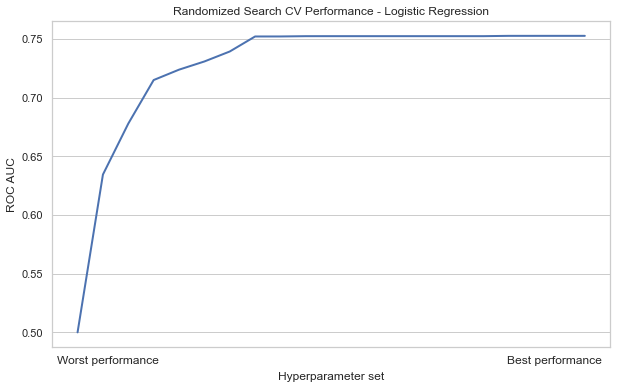

In [42]:
# plot logreg_results_auc with mean_test_roc_auc on y axis (scale 0-1) and index on x axis

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(data=logreg_results_auc['mean_test_roc_auc'], palette="tab10", linewidth=2)
plt.ylabel('ROC AUC')
plt.title('Randomized Search CV Performance - Logistic Regression')

# remove numbers on x axis

plt.xticks([])

# Add custom labels
plt.text(0.1, -0.05, 'Worst performance', transform=plt.gca().transAxes, ha='center')
plt.text(0.9, -0.05, 'Best performance', transform=plt.gca().transAxes, ha='center')
plt.text(0.5, -0.1, 'Hyperparameter set', transform=plt.gca().transAxes, ha='center')


plt.savefig('C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/03_Model/32_SMOTE_output/logreg_CV_score.png')
plt.show()

### Final Model Training

In [43]:
# load the training and testing datasets

training = pd.read_csv("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/02_Data/Cleaned/training_scaled.csv") # contains first 6 months
testing = pd.read_csv("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/02_Data/Cleaned/testing_scaled.csv") # last 2 months for testing

print("Training shape: ", training.shape)
print("Testing shape: ", testing.shape)

Training shape:  (794989, 51)
Testing shape:  (205011, 51)


In [44]:
# see in which columns there are missing values - from dataset_cleaning

missing_feature = ['prev_address_months_count', 'current_address_months_count', 'intended_balcon_amount', 'credit_risk_score', 'bank_months_count']

In [45]:
# encode any negative values with np.nan

training[missing_feature] = training[missing_feature].mask(training[missing_feature] < 0) 
testing[missing_feature] = testing[missing_feature].mask(testing[missing_feature] < 0)

# impute missing values with median
median = training[missing_feature].median()

training[missing_feature] = training[missing_feature].fillna(median)
testing[missing_feature] = testing[missing_feature].fillna(median)

In [46]:
# define dependent and independent variables 

X_train, y_train = training.drop(columns=["fraud_bool"]), training["fraud_bool"]
X_test, y_test = testing.drop(columns=["fraud_bool"]), testing["fraud_bool"]

Apply the resampling strategy on the training set

In [47]:
# apply the best resampling to the training dataset

ru = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
X_train_ru, y_train_ru = ru.fit_resample(X_train, y_train)

In [48]:
# fit the model on the training data using the best parameters found in the cross-validation

logreg = LogisticRegression_sklearn(C = best_C, class_weight = best_class_weight, penalty = best_penalty, solver = best_solver)
logreg_interpret = LogisticRegression(C = best_C, class_weight = best_class_weight, penalty = best_penalty, solver = best_solver)


logreg.fit(X_train_ru, y_train_ru)
logreg_interpret.fit(X_train_ru, y_train_ru)


In [49]:
# predict class labels on the test data
y_pred = logreg.predict(X_test)

# predict the probabilities of fraud on the test data
y_pred_proba = logreg.predict_proba(X_test)[:,1]

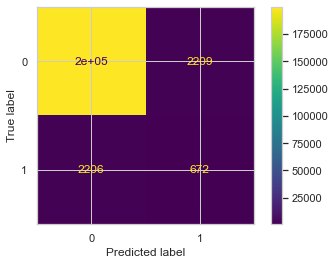

In [50]:
# Confusion matrix

matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = matrix.ravel() # get true/false positives/negatives from the confusion matrix
ConfusionMatrixDisplay(matrix).plot()

# save the confusion matrix

plt.savefig("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/03_Model/32_SMOTE_output/LogisticRegression_confusion_matrix1.png")

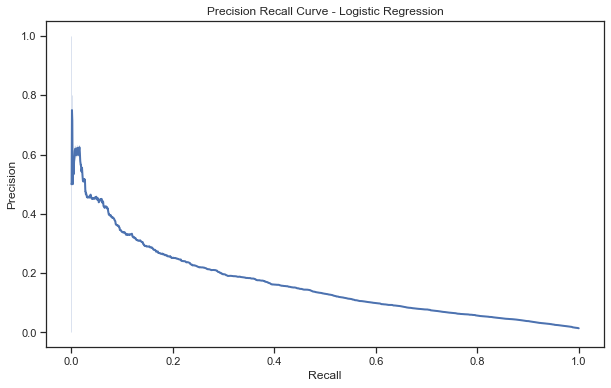

In [51]:
# get precision recall curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# plot the precision recall curve using sns lineplot

sns.set_theme(style="ticks")

plt.figure(figsize=(10, 6))
sns.lineplot(x=recall, y=precision, palette="tab10", linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve - Logistic Regression')

# save the precision recall curve

plt.savefig("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/03_Model/32_SMOTE_output/LogisticRegression_precision_recall_curve1.png")

plt.show()

In [52]:
# Define the threshold based on FPR (max recall with less than 5% FPR)
FPR_LIM = 0.05

# Score the test set
scored_test = logreg.predict_proba(X_test)[:,1]

# Calculate the ROC curve points
fpr, tpr, threshold = roc_curve(y_test, scored_test,)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Obtain the threshold and TPR based on the FPR
obtained_tpr = tpr[fpr<FPR_LIM][-1]
obtained_threshold = threshold[fpr<FPR_LIM][-1]
obtained_fpr = fpr[fpr<FPR_LIM][-1]


# make final predicitons using model threshold
final_predictions = (y_pred_proba >= obtained_threshold).astype(int)

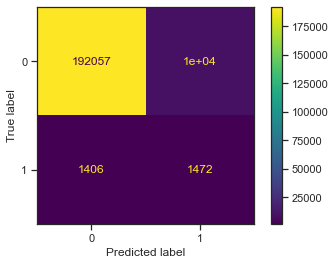

In [53]:
# Confusion matrix

matrix = confusion_matrix(y_test, final_predictions)
tn, fp, fn, tp = matrix.ravel() # get true/false positives/negatives from the confusion matrix
ConfusionMatrixDisplay(matrix).plot()

# save the confusion matrix

plt.savefig("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/03_Model/32_SMOTE_output/LogisticRegression_confusion_matrix2.png")


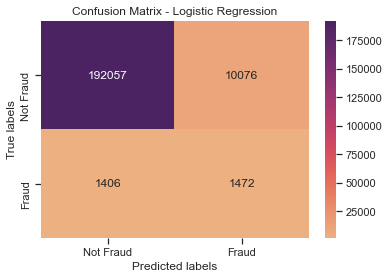

In [54]:
# plot the confusion matrix using seaborn with sns.color_palette("flare", as_cmap=True)

ax = plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, cmap=sns.color_palette("flare", as_cmap=True), fmt="g") #annot=True to annotate cells

# labels, title and ticks

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Logistic Regression')
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'])

# save the confusion matrix

plt.savefig("US_LR_confusion_matrix4.png")

# show the plot

plt.show()

In [55]:
print(f"""
Model TPR: {round(obtained_tpr, 4)}
Model FPR: {round(obtained_fpr, 4)}
Model Threshold : {round(obtained_threshold, 4)}
---
Model ROC AUC: {round(roc_auc, 4)}
F-1 score: {round(f1_score(y_test, final_predictions),4)}
""")

# print classification report for the final model

print(classification_report(y_test, final_predictions))


Model TPR: 0.5115
Model FPR: 0.0498
Model Threshold : 0.2542
---
Model ROC AUC: 0.8833
F-1 score: 0.2041

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    202133
           1       0.13      0.51      0.20      2878

    accuracy                           0.94    205011
   macro avg       0.56      0.73      0.59    205011
weighted avg       0.98      0.94      0.96    205011



In [56]:
# Obtain the ROC curve points
fpr, tpr, threshold = roc_curve(y_test, scored_test)

#fpr2, tpr2, threshold = roc_curve(y_test, final_predictions)
roc_auc = auc(fpr, tpr)

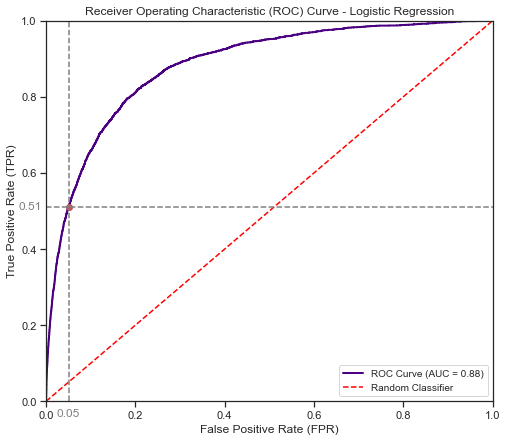

In [57]:
# including the threshold
desired_fpr = FPR_LIM

# Increase figure size
plt.figure(figsize=(8, 7))

# Plot ROC curve with improved aesthetics
plt.plot(fpr, tpr, color='indigo', linewidth=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier', linewidth=1.5)

# Set plot limits and gridlines
plt.xlim([-0.00, 1.00])
plt.ylim([-0.00, 1.00])
#plt.grid(False, linestyle='--', alpha=0.7)

# Set labels and title
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression', fontsize=12)

# Add line for desired FPR
desired_fpr_index = np.argmax(fpr >= desired_fpr)  # Find index corresponding to desired FPR
desired_fpr = fpr[desired_fpr_index]
desired_tpr = tpr[desired_fpr_index]
plt.plot(desired_fpr, desired_tpr, 'ro')  # Plot a red dot at the intersection point
plt.axvline(x=desired_fpr, linestyle='--', color='gray', linewidth=1.5)
plt.axhline(y=desired_tpr, linestyle='--', color='gray', linewidth=1.5)
plt.annotate(f'{desired_fpr:.2f}', xy=(desired_fpr, 0), xytext=(desired_fpr, -0.02),
             color='gray', ha='center', va='top')
plt.annotate(f'{desired_tpr:.2f}', xy=(0, desired_tpr), xytext=(-0.01, desired_tpr),
             color='gray', ha='right', va='center')

# Adjust legend position
plt.legend(loc="lower right", fontsize=10)

# Save the plot
plt.savefig('LR_IMB_ROC_curve2.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [58]:
# import the pickle library

import pickle

# store the model in a pickle file

pickle.dump(logreg, open("US_logreg_model.pkl", "wb"))
pickle.dump(logreg_interpret, open("US_logreg_interpret.pkl", "wb"))

# load the model from a pickle file

logreg_model = pickle.load(open("US_logreg_model.pkl", "rb"))
logreg_interpret = pickle.load(open("US_logreg_interpret.pkl", "rb"))


In [59]:
# save fpr and tpr to csv

fpr = pd.DataFrame(fpr)
tpr = pd.DataFrame(tpr)

fpr.to_csv("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/03_Model/41_ROC/US_LR_fpr.csv")
tpr.to_csv("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/03_Model/41_ROC/US_LR_tpr.csv")

### Explainable AI

In [60]:
show(logreg_interpret.explain_global())

Manually

In [61]:
# plot feature importance for the final model

coef = logreg.coef_[0]
abs_coef = np.abs(coef)

feature_importance = coef/np.sum(abs_coef)
abs_feature_importance = np.abs(feature_importance)

In [62]:
LR_feature_importance = pd.DataFrame(abs_feature_importance)

# add row names
LR_feature_importance.index = X_train.columns

LR_feature_importance.head()

,0
income,0.029740
name_email_similarity,0.034713
prev_address_months_count,0.027528
current_address_months_count,0.006235
customer_age,0.056480


In [63]:
# save feature importance to csv
LR_feature_importance.to_csv("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/03_Model/42_XAI/LR_feature_importance.csv")

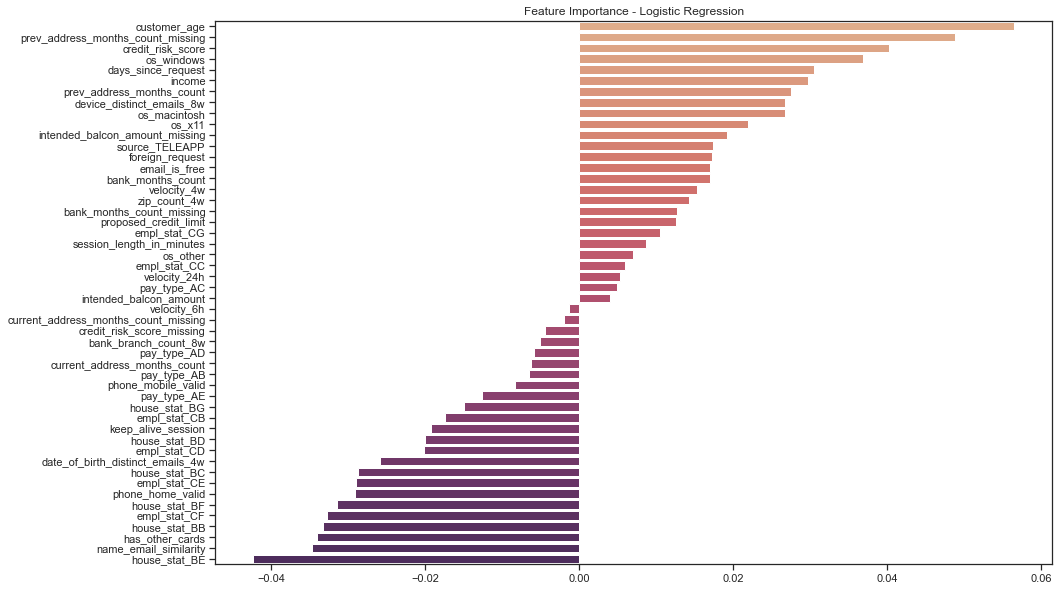

In [64]:
# feature importance

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# plot feature importance using sns barplot

plt.figure(figsize=(15, 10))
sns.barplot(x=feature_importance[indices], y=X.columns[indices], orient='h', palette="flare")
plt.title("Feature Importance - Logistic Regression")
plt.savefig("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/03_Model/32_SMOTE_output/LR_feature_importance.png")
plt.show()

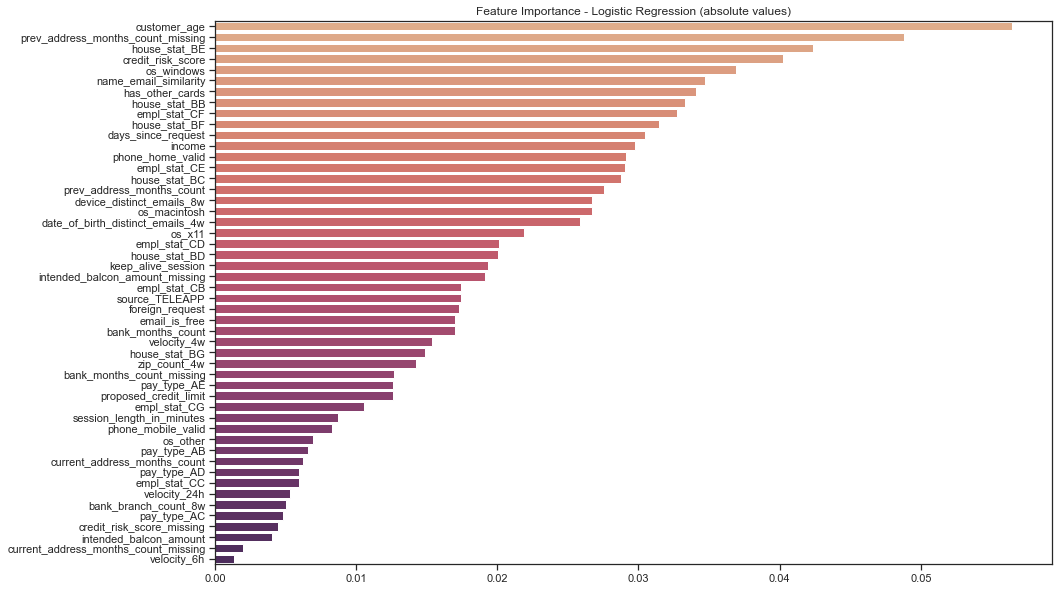

In [65]:
# absolute feature importance

# Sort feature importances in descending order
indices = np.argsort(abs_feature_importance)[::-1]

# plot feature importance using sns barplot

plt.figure(figsize=(15, 10))
sns.barplot(x=abs_feature_importance[indices], y=X.columns[indices], orient='h', palette="flare")
plt.title("Feature Importance - Logistic Regression (absolute values)")

plt.savefig("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/03_Model/32_SMOTE_output/LR_feature_importance_abs.png")
plt.show()

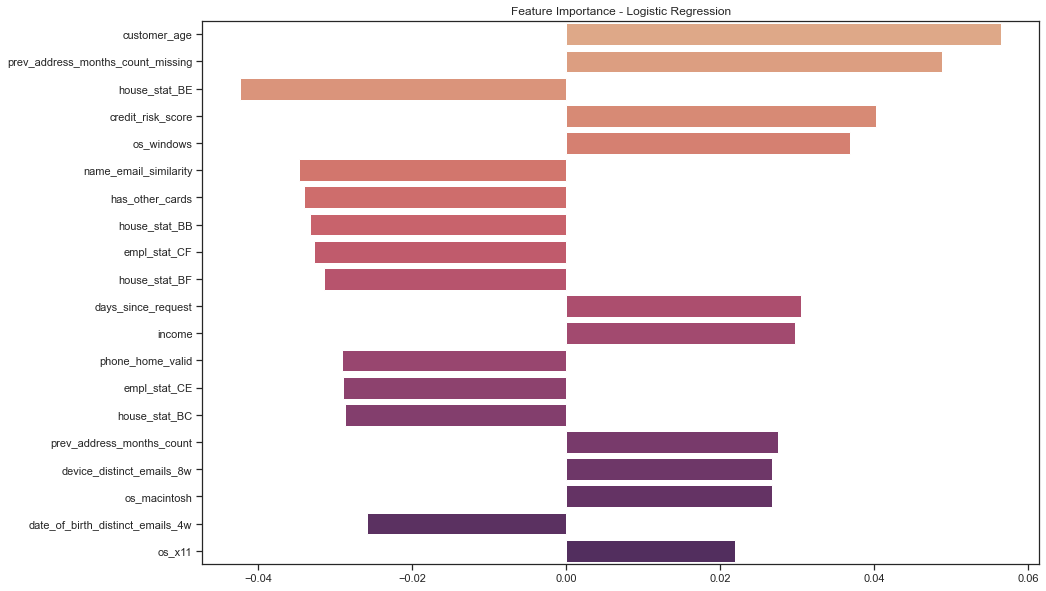

In [66]:
# plot only 20 most important features, use colors from color_palette("flare", as_cmap=True)

plt.figure(figsize=(15, 10))
sns.barplot(x=feature_importance[indices][:20], y=X.columns[indices][:20], orient='h', palette="flare")
plt.title("Feature Importance - Logistic Regression")

plt.savefig("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/03_Model/32_SMOTE_output/LR_feature_importance_abs_20.png")
plt.show()